In [1]:
# https://machinelearningmastery.com/method-of-lagrange-multipliers-the-theory-behind-support-vector-machines-part-3-implementing-an-svm-from-scratch-in-python/
import numpy as np    
# For optimization
from scipy.optimize import Bounds, BFGS                     
from scipy.optimize import LinearConstraint, minimize   
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# For generating dataset
import sklearn.datasets as dt
import pandas as pd

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


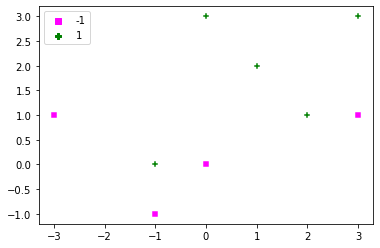

In [2]:
# 1. Data
dat = np.array([[0, 3], [-1, 0], [1, 2], [2, 1], [3,3], [0, 0], [-1, -1], [-3, 1], [3, 1]])
labels = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1])
ZERO = 1e-7

def plot_x(x, t, alpha=[], C=0):
    sns.scatterplot(dat[:,0], dat[:, 1], style=labels,
    hue=labels, markers=['s', 'P'],
    palette=['magenta', 'green'])
    if len(alpha) > 0:
        alpha_str = np.char.mod('%.1f', np.round(alpha, 1))
        ind_sv = np.where(alpha > ZERO)[0]
        for i in ind_sv:   
            plt.gca().text(dat[i,0], dat[i, 1]-.25, alpha_str[i] )

                  
plot_x(dat, labels)

In [3]:
# 2. Objective function

SVM classifier memaksimalkan Lagrange dual yang diberikan oleh persamaan berikut:

$$L_d = -\frac{1}{2} \sum_i \sum_k \alpha_i \alpha_k t_i t_k (x_i)^T (x_k) + \sum_i \alpha_i
$$

In [4]:
# Objective function
def lagrange_dual(alpha, x, t):
    result = 0
    ind_sv = np.where(alpha > ZERO)[0]
    for i in ind_sv:
        for k in ind_sv:
            result = result + alpha[i]*alpha[k]*t[i]*t[k]*np.dot(x[i, :], x[k, :]) 
    result = 0.5*result - sum(alpha)     
    return result

In [5]:
# 3. Pendefinisian konstrain linier

Dengan konstrain

$$\begin{eqnarray}
0 \leq \alpha_i \leq C, & \forall i
\end{eqnarray}$$


$$\begin{eqnarray}
\sum_i \alpha_i t_i = 0&
\end{eqnarray}$$

atau dapat ditulisakn menjadi
$$\alpha_0 t_0 + \alpha_1 t_1 + \ldots \alpha_m t_m = 0$$

atau dalam bentuk matrix
$$\begin{equation}
0 =
\begin{bmatrix}
t_0 & t_1 & \ldots t_m
\end{bmatrix}
\begin{bmatrix}
\alpha_0\\ \alpha_1 \\ \vdots \\ \alpha_m
\end{bmatrix}
= 0
\end{equation}$$

In [6]:
linear_constraint = LinearConstraint(labels, [0], [0])


In [7]:
# 4. Pendefinisian batas
# 0 > alpha > C
# Contoh C = 10
bounds_alpha = Bounds(np.zeros(dat.shape[0]), np.full(dat.shape[0], 10))
print(bounds_alpha)

Bounds(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([10, 10, 10, 10, 10, 10, 10, 10, 10]))


In [8]:
# 5. Fungsi untuk mendapatkan Alpha
def optimize_alpha(x, t, C):
    m, n = x.shape
    np.random.seed(1)
    # Initialize alphas to random values
    alpha_0 = np.random.rand(m)*C
    # Define the constraint
    linear_constraint = LinearConstraint(t, [0], [0])
    # Define the bounds
    bounds_alpha = Bounds(np.zeros(m), np.full(m, C))
    # Find the optimal value of alpha
    result = minimize(lagrange_dual, alpha_0, args = (x, t), method='trust-constr', 
                      hess=BFGS(), constraints=[linear_constraint],
                      bounds=bounds_alpha)
    # The optimized value of alpha lies in result.x
    alpha = result.x
    return alpha


alpha = optimize_alpha(dat, labels, 10)
alpha

array([2.35421893e-07, 9.99999994e+00, 3.26530741e+00, 9.99999976e+00,
       9.62142649e-08, 7.59183767e+00, 1.19831429e-07, 5.67346972e+00,
       9.99999992e+00])

In [9]:
# 6. Penentuan Hyperplane

Hyperplane diberikan oleh persamaan
$$w^T x + w_0 = 0$$

maka diperlukan 
$$w = \sum_i \alpha_i t_i x_i$$
dan 
$$w_0 = t_s – w^T x_s$$

In [10]:
def get_w(alpha, t, x):
    m = len(x)
    # Get all support vectors
    w = np.zeros(x.shape[1])
    for i in range(m):
        w = w + alpha[i]*t[i]*x[i, :]        
    return w
w = get_w(alpha, labels, dat)
w

array([0.2857168 , 0.85714604])

In [11]:

def get_w0(alpha, t, x, w, C):
    C_numeric = C-ZERO
    # Indices of support vectors with alpha<C
    ind_sv = np.where((alpha > ZERO)&(alpha < C_numeric))[0]
    w0 = 0.0
    for s in ind_sv:
        w0 = w0 + t[s] - np.dot(x[s, :], w)
    # Take the average    
    w0 = w0 / len(ind_sv)
    return w0
w0 = get_w0(alpha, labels, dat, w, 10)
w0

-0.8095265757258557

In [12]:
#  Mengkelasifikasikan titik


$$\text{label}_{x_{test}} = \text{sign}(y(x_{test})) = \text{sign}(w^T x_{test} + w_0)$$

In [13]:
def classify_points(x_test, w, w0):
    # get y(x_test)
    predicted_labels = np.sum(x_test*w, axis=1) + w0
    predicted_labels = np.sign(predicted_labels)
    # Assign a label arbitrarily a +1 if it is zero
    predicted_labels[predicted_labels==0] = 1
    return predicted_labels

predictions = classify_points(dat, w, w0)
predictions

array([ 1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.])

In [14]:

def misclassification_rate(labels, predictions):
    total = len(labels)
    errors = sum(labels != predictions)
    return errors/total*100

error = misclassification_rate(labels, predictions)
error

22.22222222222222

In [15]:
# Plot margin dan hyperplane
def plot_hyperplane(w, w0):
    x_coord = np.array(plt.gca().get_xlim())
    y_coord = -w0/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, y_coord, color='red')

def plot_margin(w, w0):
    x_coord = np.array(plt.gca().get_xlim())
    ypos_coord = 1/w[1] - w0/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, ypos_coord, '--', color='green') 
    yneg_coord = -1/w[1] - w0/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, yneg_coord, '--', color='magenta')

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


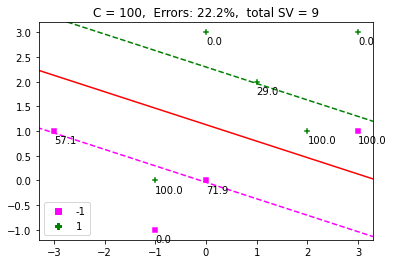

In [16]:
def display_SVM_result(x, t, C):
    # Get the alphas
    alpha = optimize_alpha(x, t, C)   
    # Get the weights
    w = get_w(alpha, t, x)
    w0 = get_w0(alpha, t, x, w, C)
    plot_x(x, t, alpha, C)
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plot_hyperplane(w, w0)
    plot_margin(w, w0)
    plt.xlim(xlim)
    plt.ylim(ylim)
    # Get the misclassification error and display it as title
    predictions = classify_points(x, w, w0)
    err = misclassification_rate(t, predictions)
    title = 'C = ' + str(C) + ',  Errors: ' + '{:.1f}'.format(err) + '%'
    title = title + ',  total SV = ' + str(len(alpha[alpha > ZERO]))
    plt.title(title)
    
display_SVM_result(dat, labels, 100)    
plt.show()

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


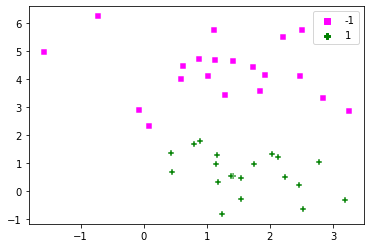

In [17]:
# Efek dari C
dat, labels = dt.make_blobs(n_samples=[20,20],
                           cluster_std=1,
                           random_state=0)
labels[labels==0] = -1
plot_x(dat, labels)

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as z

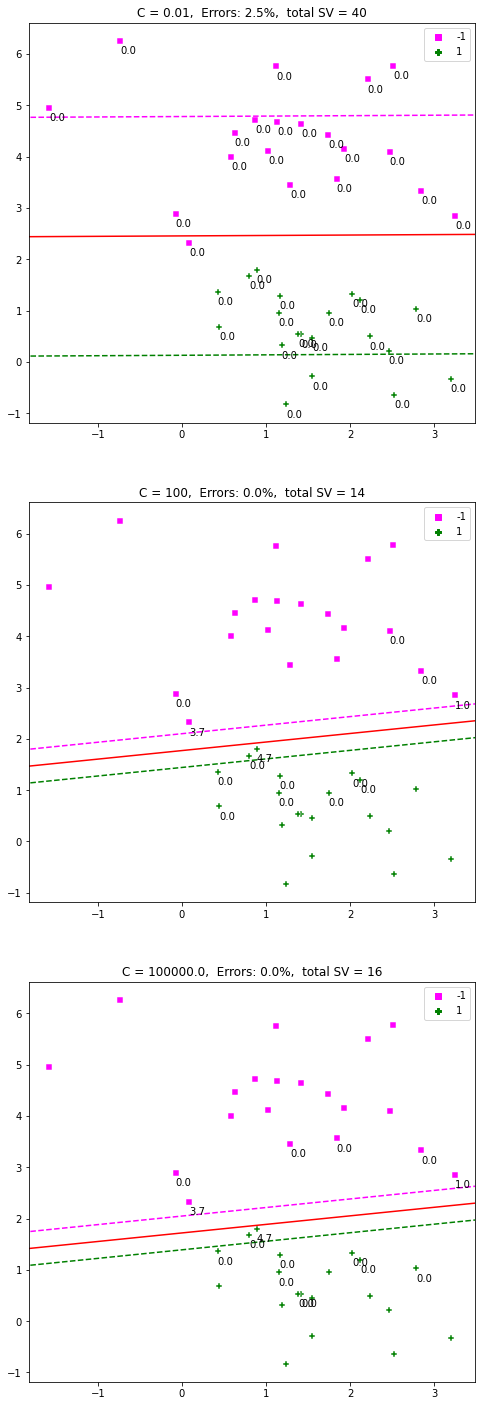

In [18]:
fig = plt.figure(figsize=(8,25))

i=0
C_array = [1e-2, 100, 1e5]

for C in C_array:
    fig.add_subplot(311+i)    
    display_SVM_result(dat, labels, C)  
    i = i + 1

In [19]:
# Meningkatkan C akan menurunkan margin, mengecilkan 
# salah klasifikasi
# Source: https://machinelearningmastery.com/method-of-lagrange-multipliers-the-theory-behind-support-vector-machines-part-3-implementing-an-svm-from-scratch-in-python/


# By package


In [20]:
# Supervised learning - Regressi
#                     - Classifikasi

# Kapan pakai Regresi?
#     - label/traget memiliki nilai yang continyu
#     Panjang meja
#     1.1 m
#     1.15 m
#     1.0005 m
#     [1 m, 2 m]

# Kapan pakai classifikasi?
#     - label/traget memiliki nilai yang diskrit (grup) bisa dilabeli dengan
#     bilangan integer
#     versicolor -> 0
#     virginica  -> 1
#     setosa     -> 2

# -------------------------------------------------------
# Umur_siswa  | jumlah_pensil_yang_pernah_dibeli (target)
# -------------------------------------------------------
# 1.1           11
# 5.2           560
# ...           ...
# -------------------------------------------------------

# -------------------------------------------------------
# ukuran_jeruk  | asal_jeruk_kota (target ada 100an kota)
# -------------------------------------------------------
#     1.1           jakarta
#     5.2           bandung
# ...           ...
# -------------------------------------------------------

In [21]:
# https://www.kaggle.com/rakeshrau/social-network-ads
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [22]:
df = pd.read_csv('Social_Network_Ads.csv')
df = df[['Age', 'EstimatedSalary', 'Purchased']]
df.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [23]:
# Target --> Purchased
list(set(list(df['Purchased'])))

[0, 1]

In [24]:
df.tail()

,Age,EstimatedSalary,Purchased
395,46,41000,1
396,51,23000,1
397,50,20000,1
398,36,33000,0
399,49,36000,1


In [25]:
# parameter
feature = ['Age', 'EstimatedSalary']

# label
target = ['Purchased']

In [26]:
# gambar ---> gambar apa?
# 255*255*3  -> tumor/bukan
# [[1,2,3,2], [2,,4,3,]] --> 65025

# gambar --> vektorisasi --> ML

# Feature generator/Feature enginering --> feature_tools python


In [27]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
len(df_train), len(df_test), len(df)

(320, 80, 400)

In [28]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

scaled_feature = [x + '_scalled' for x in feature]
sc.fit(df_train[feature])



StandardScaler()

In [29]:
df_train[scaled_feature] = sc.transform(df_train[feature])
df_test[scaled_feature] = sc.transform(df_test[feature])
df_test.head()

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying

,Age,EstimatedSalary,Purchased,Age_scalled,EstimatedSalary_scalled
213,35,58000,0,-0.276253,-0.297973
224,35,60000,0,-0.276253,-0.238360
319,36,60000,0,-0.179745,-0.238360
233,49,86000,1,1.074853,0.536612
67,23,82000,0,-1.434344,0.417385


In [30]:
# Profile data setelah di scalled: min max

print(min(df_test['Age_scalled']), max(df_test['Age_scalled']))
print(min(df_test['EstimatedSalary_scalled']), max(df_test['EstimatedSalary_scalled']))

-1.916881551723658 2.1364362668990555
-1.579655709827792 2.4442328841082075


In [31]:
# Profile data: min max
print(min(df_test['Age']), max(df_test['Age']))
print(min(df_test['EstimatedSalary']), max(df_test['EstimatedSalary']))


18 60
15000 150000


In [32]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', random_state=0)


In [33]:
classifier.fit(df_train[scaled_feature], df_train[target])


/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(random_state=0)

In [34]:
classifier2 = SVC(kernel='rbf', random_state=0)
classifier2.fit(df_train[feature], df_train[target])

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(random_state=0)

In [35]:
df_train['prediction'] = classifier.predict(df_train[scaled_feature])
df_train.head()

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Age,EstimatedSalary,Purchased,Age_scalled,EstimatedSalary_scalled,prediction
389,48,35000,1,0.978345,-0.983524,1
386,49,39000,1,1.074853,-0.864298,1
316,54,104000,1,1.557391,1.073130,1
232,40,107000,1,0.206285,1.162550,1
280,59,88000,1,2.039929,0.596225,1


In [36]:
df_train['prediction2'] = classifier2.predict(df_train[feature])
df_train.head()

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Age,EstimatedSalary,Purchased,Age_scalled,EstimatedSalary_scalled,prediction,prediction2
389,48,35000,1,0.978345,-0.983524,1,0
386,49,39000,1,1.074853,-0.864298,1,0
316,54,104000,1,1.557391,1.073130,1,1
232,40,107000,1,0.206285,1.162550,1,1
280,59,88000,1,2.039929,0.596225,1,0


In [37]:
# Kita buat 2 model
# 1. classifier: pakai preprosesing (standard scaller) --> agar 
#         nilai-nilai di features serupa
# 2. classifier2: tanpa preprocesing
    
# nanti kita cek akurasinya dari kedua model tersebut, mana yang bagus?

In [38]:
df_test['prediction'] = classifier.predict(df_test[scaled_feature])
df_test['prediction2'] = classifier2.predict(df_test[feature])
df_test.tail()

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Age,EstimatedSalary,Purchased,Age_scalled,EstimatedSalary_scalled,prediction,prediction2
132,30,87000,0,-0.758791,0.566418,0,0
299,46,117000,1,0.785330,1.460616,1,1
191,19,26000,0,-1.820374,-1.251783,0,0
377,42,53000,0,0.399300,-0.447006,0,0
6,27,84000,0,-1.048313,0.476998,0,0


In [39]:
# Model 1: classifier
#     Pipeline:
#         data --> preprocesing(standard scaller) --> SVC
# Model 2: classifier2
#     Pipeline:
#         data --> SVC
    

In [40]:
# Berapa banyak yang terprediksi benar dan
# berapa banyak yang terpredisi salah?
# Confusion matrix

# actual\predicted P   N
#    P             TP  FN 
#    N             FP  TN


from sklearn.metrics import confusion_matrix, accuracy_score

cm1 = confusion_matrix(df_test['Purchased'], df_test['prediction'])
print("Confusion matrix:\n", cm1)
acc1 = accuracy_score(df_test['Purchased'], df_test['prediction'])
print('Accuracy:\n', acc1)

Confusion matrix:
 [[46  7]
 [ 2 25]]
Accuracy:
 0.8875


In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm2 = confusion_matrix(df_test['Purchased'], df_test['prediction2'])
print("Confusion matrix model 2:\n", cm2)
acc2 = accuracy_score(df_test['Purchased'], df_test['prediction2'])
print('Accuracy model 2:\n', acc2)

Confusion matrix model 2:
 [[49  4]
 [12 15]]
Accuracy model 2:
 0.8


In [42]:
from matplotlib.colors import ListedColormap



In [43]:
X_set, y_set = df_test[scaled_feature].values, df_test[target].values.T[0]
y_set


array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0])

In [44]:
df_test[target].values.T[0]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


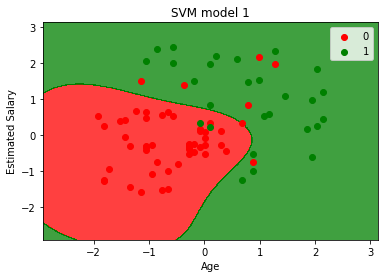

In [45]:
X1, X2 = np.meshgrid(
    np.arange(
        start=X_set[:, 0].min() - 1, 
        stop=X_set[:, 0].max() + 1, 
        step=0.01),
    np.arange(
        start=X_set[:, 0].min() - 1, 
        stop=X_set[:, 0].max() + 1, 
        step=0.01))

plt.contourf(
    X1, 
    X2, 
    classifier.predict(
        np.array([X1.ravel(), 
                  X2.ravel()]).T).reshape(X1.shape),
            alpha=0.75,
            cmap=ListedColormap(
                ('red', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0],
        X_set[y_set == j, 1],
        c=ListedColormap(('red', 'green'))(i),
        label=j)

plt.title('SVM model 1')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()
    
    
    



In [46]:
print("Confusion matrix model 1:\n", cm1)


Confusion matrix model 1:
 [[46  7]
 [ 2 25]]


In [47]:
# X_set, y_set = df_test[feature].values, df_test[target].values.T[0]

# X1, X2 = np.meshgrid(
#     np.arange(
#         start=X_set[:, 0].min() - 1, 
#         stop=X_set[:, 0].max() + 1, 
#         step=0.01),
#     np.arange(
#         start=X_set[:, 0].min() - 1, 
#         stop=X_set[:, 0].max() + 1, 
#         step=0.01))

# plt.contourf(
#     X1, 
#     X2, 
#     classifier2.predict(
#         np.array([X1.ravel(), 
#                   X2.ravel()]).T).reshape(X1.shape),
#             alpha=0.75,
#             cmap=ListedColormap(
#                 ('red', 'green')))

# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())

# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(
#         X_set[y_set == j, 0],
#         X_set[y_set == j, 1],
#         c=ListedColormap(('red', 'green'))(i),
#         label=j)

# plt.title('SVM model 1')
# plt.xlabel('Age')
# plt.ylabel('Estimated Salary')
# plt.legend()
# plt.show()
    
    
    


In [48]:
print("Confusion matrix model 2:\n", cm2)


Confusion matrix model 2:
 [[49  4]
 [12 15]]


# Iris data

In [49]:
def get_df_with_string():
    cols = ['sepal length', 
           'sepal width',
           'petal length',
           'petal width']
    iris = dt.load_iris()
    target_dict = {
        0: 'setosa',
        1: 'versicolor',
        2: 'virginica'
    }
    target = iris.target
    new_target = []
    for t in target:
        new_target.append(target_dict[t])
    print("target_name: ", set(new_target))
    df = pd.DataFrame(iris.data)
    df.columns = cols
    df['target'] = new_target
    df['target_int'] = target
    return df

data = get_df_with_string()
data.tail()

target_name:  {'versicolor', 'setosa', 'virginica'}


,sepal length,sepal width,petal length,petal width,target,target_int
145,6.7,3.0,5.2,2.3,virginica,2
146,6.3,2.5,5.0,1.9,virginica,2
147,6.5,3.0,5.2,2.0,virginica,2
148,6.2,3.4,5.4,2.3,virginica,2
149,5.9,3.0,5.1,1.8,virginica,2


In [50]:
df = data[(data['target'] == 'virginica') |  (data['target'] == 'versicolor')]

In [53]:
def get_x_t(df, cols):
    feat1 = list(df[cols[0]])
    feat2 = list(df[cols[1]])
    dat = np.array([[feat1[i], feat2[i]] for i in range(len(feat1))])
    t = np.array(list(df[cols[2]]))
    return dat, t


def plot_x(df, cols, alpha=[], C=0):
    dat, t = get_x_t(df, cols)
    sns.scatterplot(dat[:, 0], dat[:, 1], style=t,
    hue=t, markers=['s', 'P'],
    palette=['magenta', 'green'])
    if len(alpha) > 0:
        alpha_str = np.char.mod('%.1f', np.round(alpha, 1))
        ind_sv = np.where(alpha > ZERO)[0]
        for i in ind_sv:   
            plt.gca().text(dat[i, 0], dat[i, 1]-.25, alpha_str[i] )



/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


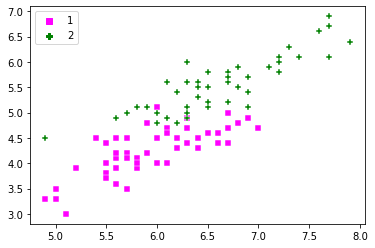

In [54]:
feature = ['sepal length', 'petal length']
target = ['target_int']
cols = feature + target
plot_x(df, cols)


/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


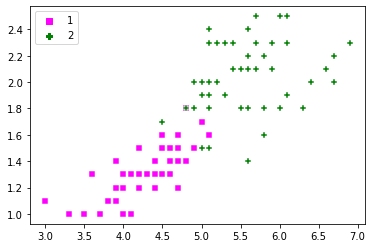

In [55]:
plot_x(df, ['petal length', 'petal width', 'target_int'])

In [56]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
len(df_train), len(df_test), len(df)

(80, 20, 100)

In [57]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

scaled_feature = [x + '_scalled' for x in feature]
sc.fit(df_train[feature])

StandardScaler()

In [58]:
df_train[scaled_feature] = sc.transform(df_train[feature])
df_test[scaled_feature] = sc.transform(df_test[feature])
df_test.head()

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying

,sepal length,sepal width,petal length,petal width,target,target_int,sepal length_scalled,petal length_scalled
94,5.6,2.7,4.2,1.3,versicolor,1,-0.948902,-0.820048
75,6.6,3.0,4.4,1.4,versicolor,1,0.499803,-0.584487
133,6.3,2.8,5.1,1.5,virginica,2,0.065192,0.239978
143,6.8,3.2,5.9,2.3,virginica,2,0.789544,1.182224
51,6.4,3.2,4.5,1.5,versicolor,1,0.210062,-0.466706


In [59]:
# Profile data setelah di scalled: min max

print(min(df_test['sepal length']), max(df_test['sepal length']))
print(min(df_test['petal length']), max(df_test['petal length']))



5.6 7.7
4.2 6.9


In [60]:

print(min(df_test['sepal length_scalled']), max(df_test['sepal length_scalled']))
print(min(df_test['petal length_scalled']), max(df_test['petal length_scalled']))



-0.9489017348149673 2.093378636347523
-0.8200483554916265 2.3600314431832627


In [61]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', random_state=0)

In [62]:
classifier.fit(df_train[scaled_feature], df_train[target])

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(random_state=0)

In [63]:
classifier2 = SVC(kernel='rbf', random_state=0)
classifier2.fit(df_train[feature], df_train[target])

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(random_state=0)

In [64]:
# This SVC class allows us to build a kernel SVM model 
# (linear as well as non-linear), 
#  The default value of the kernel is ‘rbf’. 
# Why ‘rbf’, because it is nonlinear and gives better 
# results as compared to linear.

In [65]:
df_train['prediction'] = classifier.predict(df_train[scaled_feature])
df_train.head()

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sepal length,sepal width,petal length,petal width,target,target_int,sepal length_scalled,petal length_scalled,prediction
99,5.7,2.8,4.1,1.3,versicolor,1,-0.804031,-0.937829,1
106,4.9,2.5,4.5,1.7,virginica,2,-1.962995,-0.466706,1
138,6.0,3.0,4.8,1.8,virginica,2,-0.369420,-0.113364,2
63,6.1,2.9,4.7,1.4,versicolor,1,-0.224549,-0.231145,1
70,5.9,3.2,4.8,1.8,versicolor,1,-0.514290,-0.113364,2


In [66]:
df_train['prediction2'] = classifier2.predict(df_train[feature])
df_train.head()

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sepal length,sepal width,petal length,petal width,target,target_int,sepal length_scalled,petal length_scalled,prediction,prediction2
99,5.7,2.8,4.1,1.3,versicolor,1,-0.804031,-0.937829,1,1
106,4.9,2.5,4.5,1.7,virginica,2,-1.962995,-0.466706,1,1
138,6.0,3.0,4.8,1.8,virginica,2,-0.369420,-0.113364,2,1
63,6.1,2.9,4.7,1.4,versicolor,1,-0.224549,-0.231145,1,1
70,5.9,3.2,4.8,1.8,versicolor,1,-0.514290,-0.113364,2,2


In [67]:
# Kita buat 2 model
# 1. classifier: pakai preprosesing (standard scaller) --> agar 
#         nilai-nilai di features serupa
# 2. classifier2: tanpa preprocesing
    
# nanti kita cek akurasinya dari kedua model tersebut, mana yang bagus?

In [68]:
df_test['prediction'] = classifier.predict(df_test[scaled_feature])
df_test['prediction2'] = classifier2.predict(df_test[feature])
df_test.tail()

/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/thomas/opt/miniconda3/envs/scraping_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sepal length,sepal width,petal length,petal width,target,target_int,sepal length_scalled,petal length_scalled,prediction,prediction2
61,5.9,3.0,4.2,1.5,versicolor,1,-0.514290,-0.820048,1,1
73,6.1,2.8,4.7,1.2,versicolor,1,-0.224549,-0.231145,1,1
52,6.9,3.1,4.9,1.5,versicolor,1,0.934415,0.004417,1,1
121,5.6,2.8,4.9,2.0,virginica,2,-0.948902,0.004417,2,2
74,6.4,2.9,4.3,1.3,versicolor,1,0.210062,-0.702268,1,1


In [69]:
# Model 1: classifier
#     Pipeline:
#         data --> preprocesing(standard scaller) --> SVC
# Model 2: classifier2
#     Pipeline:
#         data --> SVC
    

In [70]:
# Berapa banyak yang terprediksi benar dan
# berapa banyak yang terpredisi salah?
# Confusion matrix

# actual\predicted P   N
#    P             TP  FN 
#    N             FP  TN


from sklearn.metrics import confusion_matrix, accuracy_score

cm1 = confusion_matrix(df_test['target_int'], df_test['prediction'])
print("Confusion matrix:\n", cm1)
acc1 = accuracy_score(df_test['target_int'], df_test['prediction'])
print('Accuracy:\n', acc1)

Confusion matrix:
 [[11  0]
 [ 0  9]]
Accuracy:
 1.0


In [71]:
cm2 = confusion_matrix(df_test['target_int'], df_test['prediction2'])
print("Confusion matrix model 2:\n", cm2)
acc2 = accuracy_score(df_test['target_int'], df_test['prediction2'])
print('Accuracy model 2:\n', acc2)

Confusion matrix model 2:
 [[11  0]
 [ 0  9]]
Accuracy model 2:
 1.0


In [72]:
from matplotlib.colors import ListedColormap


In [73]:
X_set, y_set = df_test[scaled_feature].values, df_test[target].values.T[0]
y_set


array([1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1])

In [74]:
df_test[target].values.T[0]

array([1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


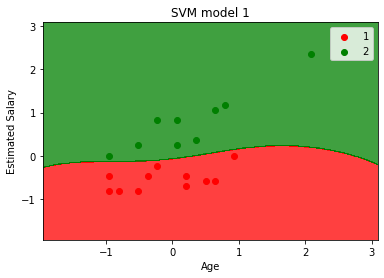

In [75]:
X1, X2 = np.meshgrid(
    np.arange(
        start=X_set[:, 0].min() - 1, 
        stop=X_set[:, 0].max() + 1, 
        step=0.01),
    np.arange(
        start=X_set[:, 0].min() - 1, 
        stop=X_set[:, 0].max() + 1, 
        step=0.01))

plt.contourf(
    X1, 
    X2, 
    classifier.predict(
        np.array([X1.ravel(), 
                  X2.ravel()]).T).reshape(X1.shape),
            alpha=0.75,
            cmap=ListedColormap(
                ('red', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0],
        X_set[y_set == j, 1],
        c=ListedColormap(('red', 'green'))(i),
        label=j)

plt.title('SVM model 1')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()
    
    
    



In [76]:
print("Confusion matrix model 1:\n", cm1)


Confusion matrix model 1:
 [[11  0]
 [ 0  9]]


In [77]:
print("Confusion matrix model 2:\n", cm2)


Confusion matrix model 2:
 [[11  0]
 [ 0  9]]
